## Importing Libraries

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from warnings import filterwarnings
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from minisom import MiniSom
from matplotlib.patches import Patch
from adjustText import adjust_text

filterwarnings('ignore')

## Load the dataset

In [178]:
# Load the dataset
columns = ['id', 'content']
df = pd.read_csv('WikipediaEvents.csv', header=None, names=columns)
df.drop('id', axis=1, inplace=True)
pure_df = df.copy()
labels = df['content'].apply(lambda x: x.split('–', 1)[0])
labels

## Preprocessing Removing Stopwords, Tokenization

In [181]:

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if isinstance(text, str):
        # Tokenization
        tokens = word_tokenize(text)
    elif isinstance(text, list):
        tokens = text
    else:
        raise TypeError("Input should be a string or a list of words")

    # Stop words removal
    new_tokens = [word.lower() for word in tokens if word not in stop_words]

    return new_tokens

df['content'] = df['content'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## GloVe Model

In [183]:
# Load the GloVe model
glove_input_file = '../../glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

## Convert the text data to vectors

In [263]:
def check_existence(word, model, vector_size):
    try:
        return model[word]
    except:
        return np.zeros(vector_size)
data = pd.DataFrame(df['content'].apply(lambda words: np.mean([check_existence(word, glove_model, 100) for word in words], axis=0)))
data = pd.DataFrame(data['content'].to_list())

## Train and Tune Hyperparmeter the MiniSom Model, Get Winning Units

In [271]:
grid_sigma = [0.1, 0.5, .01]
grid_learning_rate = [0.1, 0.5, 0.01]
grid_x_y = [(2,2), (6,6), (10,10)]
num_features = data.shape[1]
best_params = None
best_score = np.inf
for sigma in grid_sigma:
    for learning_rate in grid_learning_rate:
        for x_y in grid_x_y:
            som = MiniSom(x=x_y[0], y=x_y[1], input_len=num_features, sigma=sigma, learning_rate=learning_rate, neighborhood_function='gaussian')
            som.random_weights_init(data.values)
            som.train_random(data.values, num_iteration=10000, verbose=True)

            score = som.quantization_error(data.values)
            if score < best_score:
                best_params = {'sigma': sigma, 'learning_rate': learning_rate, 'x_y': x_y}
                best_score = score
                best_som = som

# Print the best parameters and the corresponding score
print(f"Best HyperParameter for SOM model in our Data: {best_params} with score: {best_score}")
som = best_som
winning_units = np.array([som.winner(x) for x in data.values])

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.19784323083822
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.9453845143993539
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.7778672338519133
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.2404572698739882
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.9677322808054012
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.7671698298316052
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.2495369529565752
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.9726646449374929
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.8243348191875597
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.1967408584662826
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.9336394848505313
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.7790392190985839
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 q

## Add the Winning Units Columns to the Data

In [215]:
data['winning_unit'] = list(map(str, winning_units))
pure_df['winning_unit'] = list(map(str, winning_units))

In [246]:
pure_df

,content,winning_unit
0,"January 1, 2022 – The Regional Comprehensive E...",[2 3]
1,"January 2, 2022 – Abdalla Hamdok resigns as Pr...",[8 5]
2,"January 4, 2022 – The five permanent members o...",[2 2]
3,"January 5, 2022 – A nationwide state of emerge...",[5 7]
4,"January 6, 2022 – The CSTO deploys a ""peacekee...",[7 3]
...,...,...
468,"October, 2024 – 2024 Georgian presidential ele...",[5 8]
469,"November, 2024 – 2024 Namibian general election.",[9 9]
470,"November, 2024 – 2024 Romanian presidential el...",[5 8]
471,"November, 2024 – Lee Hsien Loong, Prime Minist...",[0 0]


## Grid MAP SOM neurons (Randomly Select 50 Events and Plot the Winning Units)

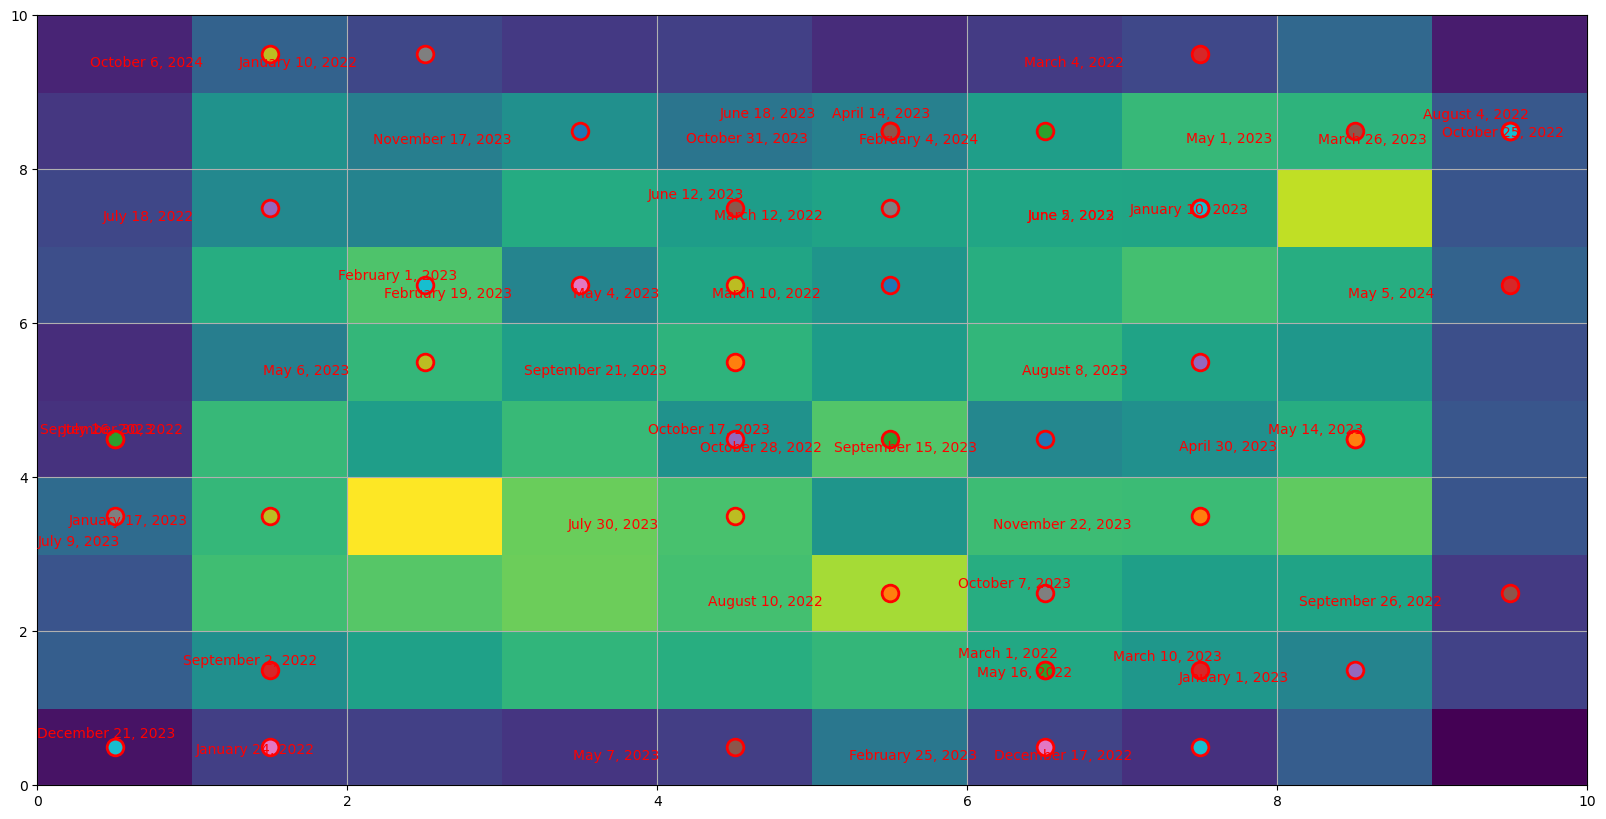

In [285]:
# Randomly select 50 events
selected_events = data.sample(n=50)
selected_winning_unit = winning_units[selected_events.index]
selected_labels = labels[selected_events.index]
plt.figure(figsize=(20, 10))
plt.pcolor(som.distance_map().T,)
texts = []
# Compute the U-matrix
u_matrix = som.distance_map()  # This computes the U-matrix of the SOM

for w, label in zip(selected_winning_unit, selected_labels):
    plt.plot(w[0] + 0.5, w[1] + 0.5, 'o', markeredgecolor='r',  markersize=12, markeredgewidth=2)
    texts.append(plt.text(w[0] , w[1] + 0.5, label, ha='center', va='center', color='red', fontsize=10))
adjust_text(texts)
# Plot the U-matrix
plt.pcolor(u_matrix.T)
# adjust the positions of the text labels
plt.axis([0, som.get_weights().shape[0], 0, som.get_weights().shape[1]])
plt.grid()
plt.show()

In [204]:
data['winning_unit'].value_counts()

winning_unit
[1 6]    24
[1 4]    20
[2 3]    20
[4 5]    18
[5 4]    15
         ..
[9 7]     1
[8 8]     1
[9 0]     1
[7 2]     1
[4 4]     1
Name: count, Length: 100, dtype: int64

## Load Questions and Preprocess and Convert to Vectors

In [234]:
qa = pd.read_table("Sample_questions.txt")
selected_questions = qa.copy()
selected_questions['questions'] = selected_questions['questions'].apply(preprocess_text)
qa_data = pd.DataFrame(selected_questions['questions'].apply(lambda words: np.mean([check_existence(word, glove_model, 100) for word in words], axis=0)))
qa_data = pd.DataFrame(qa_data['questions'].to_list())
qa_data

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.236035,0.741275,0.700114,-0.640573,-0.314830,0.189826,0.103110,0.263565,-0.385023,-0.176869,...,-0.092420,0.348192,0.141385,0.175701,-0.281490,-0.009038,-0.260535,0.115560,0.401570,0.183190
1,-0.256074,0.341562,0.532542,-0.220475,-0.149556,0.089856,0.061925,-0.013630,0.136688,-0.156098,...,0.095289,-0.217406,-0.041132,0.228265,-0.588070,0.098529,-0.012516,0.452462,0.256048,0.162910
2,-0.048132,0.394433,0.241857,-0.293370,-0.164610,0.176291,0.047400,-0.063067,0.111410,-0.051019,...,0.107765,-0.097506,-0.038478,0.298665,-0.722734,0.224356,0.016395,0.251928,-0.077196,0.160796
3,-0.036308,0.353315,0.202847,-0.325084,-0.095202,0.101594,-0.056726,-0.043409,0.106152,0.028932,...,0.173298,-0.142814,0.051271,0.282845,-0.687720,0.134083,-0.022239,0.273478,0.017620,0.136974
4,-0.111098,0.087070,0.645264,-0.335650,0.146662,0.115618,0.254202,-0.000368,0.013698,0.040466,...,-0.067254,-0.176502,-0.074231,0.447719,-0.458818,0.213210,0.236625,-0.128730,0.164234,0.249076
5,-0.120970,0.107584,0.682126,-0.312577,0.166778,0.146736,0.268182,0.051282,0.006518,0.018522,...,-0.050530,-0.134603,-0.111172,0.421987,-0.441016,0.169258,0.251965,-0.098653,0.132128,0.251148
6,0.032992,0.645782,0.623384,-0.322136,-0.527332,0.141340,0.065054,0.224342,-0.494770,-0.216030,...,-0.110998,0.291523,0.107993,0.132441,-0.292002,0.136302,0.000022,0.132133,0.115433,0.216682
7,-0.147866,0.426529,0.680129,-0.128875,-0.343741,0.065327,0.019532,0.352182,-0.531832,-0.121987,...,-0.045593,0.161468,0.007200,0.316614,-0.423088,0.118518,-0.048013,0.232539,0.141974,0.078023
8,-0.412165,-0.057214,0.605179,-0.077150,0.168243,-0.193899,-0.118774,-0.137969,0.073833,0.070841,...,0.366598,-0.093046,0.103979,0.456470,-0.532207,0.098925,-0.205252,-0.077329,0.188094,-0.280878
9,-0.165413,-0.065799,0.673076,0.056786,-0.257567,-0.091913,0.108809,0.247559,-0.021642,-0.084594,...,-0.081628,-0.206214,0.053841,0.381698,-0.568953,0.144069,-0.332471,0.063568,0.275680,-0.084185


In [242]:
external_added_clusters_dict = {}
for i in range(som.get_weights().shape[0]):
    for j in range(som.get_weights().shape[1]):
        external_added_clusters_dict[f'[{i} {j}]'] = 0

## Find the most relevant Index for the questions

In [243]:
for question_text, question in zip(qa.values, qa_data.values):
    question = question.reshape(1, -1)
    # Find the appropriate index corresponding to the question
    question_index = som.winner(question)
    question_index = f"[{question_index[0]} {question_index[1]}]"
    external_added_clusters_dict[question_index] += 1
    relevant_data = data[data['winning_unit'] == question_index]
    pure_relevant_data = pure_df[pure_df['winning_unit'] == question_index]


    # Calculate the most relevant data with cosine similarity measure
    sim = {}
    i = 0
    for relevant, text in zip(relevant_data.values, pure_relevant_data.values):
        relevant = relevant[:-1].reshape(1, -1)
        similarities = cosine_similarity(question, relevant)
        sim[i] = {"similarity": similarities[0][0], "text": text}
        i = i + 1
    max_sim = max(sim.values(), key=lambda x: x['similarity'])['similarity']
    if max_sim > 0.85:
        print(f"The cluster for question: '{question_text[0]}' is {question_index} \n number of relevant data in the index: {len(relevant_data)} \n maximum relevant data cosine similarity: {max_sim} \n most relevant data: {max(sim.values(), key=lambda x: x['similarity'])['text'][0]}")
    else:
        print(f"The cluster for question: '{question_text[0]}' is {question_index} \n number of relevant(external) data: {len(relevant_data)} \n maximum relevant data cosine similarity: {max_sim}")
    print("------------------------------------------------------------------------------------------------")

The cluster for question: 'Who won the 2022 soccer world cup?' is [4 4] 
 number of relevant data in the index: 2 
 maximum relevant data cosine similarity: 0.8748012436848903 
 most relevant data: September, 2024 – 2024 ICC Women's T20 World Cup.
------------------------------------------------------------------------------------------------
The cluster for question: 'When did Sweden join NATO?' is [0 3] 
 number of relevant data in the index: 5 
 maximum relevant data cosine similarity: 0.8924374596932739 
 most relevant data: March 7, 2024 – As the final Nordic country to join the alliance, Sweden officially joins NATO, becoming its 32nd member after Finland a year earlier.
------------------------------------------------------------------------------------------------
The cluster for question: 'Who joined NATO in 2023?' is [0 5] 
 number of relevant(external) data: 18 
 maximum relevant data cosine similarity: 0.8333107559335835
-----------------------------------------------------

## Print the External Data Added to the Clusters

In [245]:
for i in range(som.get_weights().shape[0]):
    for j in range(som.get_weights().shape[1]):
        if external_added_clusters_dict[f'[{i} {j}]']:
            print(f"External data added to this {f'[{i} {j}]'} index is {external_added_clusters_dict[f'[{i} {j}]']}")
print("Every Other Cluster is 0")

External data added to this [0 0] index is 1
External data added to this [0 3] index is 3
External data added to this [0 5] index is 2
External data added to this [4 4] index is 3
External data added to this [8 1] index is 3
External data added to this [9 2] index is 2
Every Other Cluster is 0
